# 📦 PHASE 1: Data Fetching and Engineering

In [11]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from volsense_pkg.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset
from volsense_pkg.data_fetching.fetch_yf import fetch_ohlcv
from volsense_pkg.models.global_vol_forecaster import (
    build_global_splits,
    GlobalVolForecaster,
    TrainConfig,
    train_global_model
)
from torch.utils.data import DataLoader


In [4]:
# ------------------------------------------------------------
# 1️⃣ Define universe of 105 tickers (diversified market coverage)
# ------------------------------------------------------------

TICKERS = [
    # Index ETFs
    "SPY", "QQQ", "DIA", "IWM", "VXX", "GLD", "SLV", "TLT", "HYG", "EEM",
    # Tech
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "AVGO", "AMD", "INTC", "ORCL",
    "CRM", "TXN", "QCOM", "ADI", "MU",
    # Financials
    "JPM", "BAC", "C", "WFC", "GS", "MS", "V", "MA", "AXP", "SCHW",
    # Healthcare
    "JNJ", "PFE", "MRK", "UNH", "ABBV", "ABT", "LLY", "BMY", "TMO", "CVS",
    # Energy / Materials
    "XOM", "CVX", "COP", "SLB", "HAL", "BP", "SHEL", "BHP", "RIO", "FCX",
    # Consumer Discretionary
    "TSLA", "HD", "MCD", "NKE", "SBUX", "LOW", "TGT", "BKNG", "CMG", "ROST",
    # Industrials
    "CAT", "BA", "HON", "UPS", "FDX", "UNP", "DE", "LMT", "GE", "RTX",
    # Staples / Retail
    "PG", "KO", "PEP", "COST", "WMT", "CL", "MDLZ", "KMB", "GIS", "KR",
    # Utilities / Real Estate
    "NEE", "DUK", "SO", "XEL", "AEP", "PLD", "AMT",
    # Comms / Media
    "DIS", "CMCSA", "NFLX", "T", "VZ", "TWX", "PARA", "WBD",
    # Bonus (volatile)
    "GME", "AMC", "PYPL", "COIN", "ATVI"
]

print(f"✅ Universe of tickers defined: {len(TICKERS)} total")

✅ Universe of tickers defined: 105 total


In [5]:
# ------------------------------------------------------------
# 2️⃣ Fetch historical OHLCV data (2010–2025)
# ------------------------------------------------------------

start_date = "2010-01-01"
end_date = "2025-12-31"

print(f"\n📡 Fetching data for {len(TICKERS)} tickers from {start_date} to {end_date}...\n")

data_dict = fetch_multi_ohlcv(TICKERS, start=start_date, end=end_date)

# ------------------------------------------------------------
# 3️⃣ Build unified dataset with returns and realized volatility
# ------------------------------------------------------------

LOOKBACK = 15  # short-term rolling window for volatility
multi_df = build_multi_dataset(data_dict, lookback=LOOKBACK)

print("\n✅ Combined dataset created!")
print(f"Shape: {multi_df.shape}")
print(multi_df.head())


📡 Fetching data for 105 tickers from 2010-01-01 to 2025-12-31...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


✅ Combined dataset created!
Shape: (400342, 4)
        date    return  realized_vol ticker
0 2010-01-26  0.014133      0.350305   AAPL
1 2010-01-27  0.009420      0.353315   AAPL
2 2010-01-28 -0.041322      0.385451   AAPL
3 2010-01-29 -0.036279      0.407952   AAPL
4 2010-02-01  0.013902      0.412991   AAPL


In [6]:
print(multi_df.columns)

Index(['date', 'return', 'realized_vol', 'ticker'], dtype='object')


In [7]:
# ------------------------------------------------------------
# 4️⃣ Basic Sanity Checks
# ------------------------------------------------------------

# Ensure no missing columns
assert all(c in multi_df.columns for c in ["date", "return", "realized_vol", "ticker"]), \
    "Missing required columns in dataset."

# Drop any NA
multi_df.dropna(subset=["realized_vol"], inplace=True)
multi_df.reset_index(drop=True, inplace=True)

print(f"\n🧮 After cleaning: {len(multi_df):,} rows across {multi_df['ticker'].nunique()} tickers")


🧮 After cleaning: 400,342 rows across 104 tickers


,mean,std,max,count
ticker,,,,
COIN,0.814672,0.312042,2.001921,1113
AMC,0.748119,1.050811,13.143307,2954
VXX,0.645391,0.365084,2.502239,1922
GME,0.619261,0.726918,8.580002,3951
TSLA,0.528952,0.227642,1.702790,3829
AMD,0.509421,0.229540,2.316547,3951
MU,0.449418,0.174371,1.503072,3951
FCX,0.441549,0.222512,1.989913,3951
NFLX,0.430722,0.238426,1.852551,3951


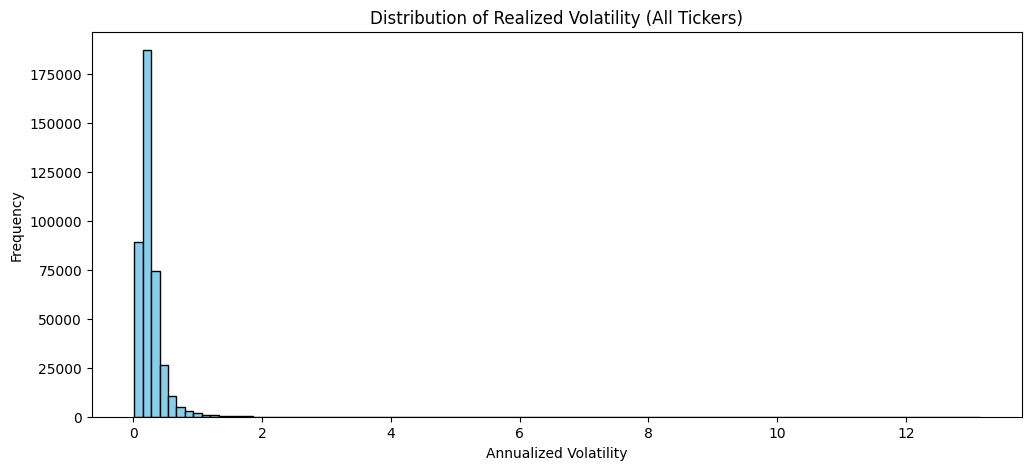

In [8]:
# ------------------------------------------------------------
# 5️⃣ Quick Summary Stats
# ------------------------------------------------------------

agg_stats = multi_df.groupby("ticker")["realized_vol"].agg(["mean", "std", "max", "count"]).sort_values("mean", ascending=False)
display(agg_stats.head(10))

plt.figure(figsize=(12,5))
plt.hist(multi_df["realized_vol"], bins=100, color="skyblue", edgecolor="black")
plt.title("Distribution of Realized Volatility (All Tickers)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Frequency")
plt.show()

In [11]:
# ------------------------------------------------------------
# 6️⃣ Save to CSV for reproducibility
# ------------------------------------------------------------

multi_df.to_csv("../data/processed/global_volatility_dataset.csv", index=False)

print("\n💾 Saved combined dataset to data/global_volatility_dataset.csv")


💾 Saved combined dataset to data/global_volatility_dataset.csv


# PHASE 2: Model Training

## Baseline Model: Stride = 2, layers = 3, hidden layers = 64

In [10]:
# Ensure PyTorch runs efficiently on CPU
torch.set_num_threads(max(1, os.cpu_count() // 2))

# --- Parameters
WINDOW      = 30          # lookback window for LSTM
HORIZONS    = 1           # forecast 1 day ahead
STRIDE      = 2           # sampling stride
VAL_START   = "2025-01-01"  # everything after = validation
DEVICE      = "cpu"

# --- 1. Split the dataset into training and validation sets
train_ds, val_ds, ticker_to_id, scalers = build_global_splits(
    df=multi_df,
    window=WINDOW,
    horizons=HORIZONS,
    stride=STRIDE,
    val_start=VAL_START
)

print(f"✅ Train samples: {len(train_ds):,} | Val samples: {len(val_ds):,}")
print(f"✅ Tickers mapped: {len(ticker_to_id)}")

# --- 2. Define model and training config
cfg = TrainConfig(
    epochs=10,               # start small, tune later
    lr=1e-3,
    batch_size=256,
    oversample_high_vol=True,
    early_stop_patience=3,
    device=DEVICE
)

model = GlobalVolForecaster(
    n_tickers=len(ticker_to_id),
    window=WINDOW,
    n_horizons=(HORIZONS if isinstance(HORIZONS, int) else len(HORIZONS)),
    emb_dim=8,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
)

# --- 3. Train the model
history = train_global_model(model, train_ds, val_ds, cfg)

✅ Train samples: 188,773 | Val samples: 9,888
✅ Tickers mapped: 104
Epoch 1/10 | Train Loss: 0.3301 | Val Loss: 0.1781
Epoch 2/10 | Train Loss: 0.1848 | Val Loss: 0.1736
Epoch 3/10 | Train Loss: 0.1780 | Val Loss: 0.1667
Epoch 4/10 | Train Loss: 0.1726 | Val Loss: 0.1612
Epoch 5/10 | Train Loss: 0.1686 | Val Loss: 0.1582
Epoch 6/10 | Train Loss: 0.1648 | Val Loss: 0.1554
Epoch 7/10 | Train Loss: 0.1583 | Val Loss: 0.1442
Epoch 8/10 | Train Loss: 0.1495 | Val Loss: 0.1383
Epoch 9/10 | Train Loss: 0.1447 | Val Loss: 0.1333
Epoch 10/10 | Train Loss: 0.1422 | Val Loss: 0.1332


In [11]:
import math

# Function to unscale back to volatility
def inverse_to_vol(y_scaled: np.ndarray, tkr_ids: np.ndarray) -> np.ndarray:
    out = []
    inv_t2i = {v: k for k, v in ticker_to_id.items()}
    y_scaled = np.atleast_2d(y_scaled)
    for idx, row in enumerate(y_scaled):
        tkr = inv_t2i[int(tkr_ids[idx])]
        sc = scalers[tkr]
        y_log = sc.inverse_transform(row.reshape(-1, 1)).flatten()
        out.append(np.exp(y_log))
    out = np.stack(out)
    return out.squeeze()

# Evaluate on validation set
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
yhat_scaled_all, ytrue_scaled_all, tid_all = [], [], []

model.eval()
with torch.no_grad():
    for t_id, X, y in val_loader:
        yhat = model(t_id, X)
        yhat_scaled_all.append(yhat.cpu().numpy())
        ytrue_scaled_all.append(y.cpu().numpy())
        tid_all.append(t_id.cpu().numpy())

yhat_scaled = np.concatenate(yhat_scaled_all, axis=0)
ytrue_scaled = np.concatenate(ytrue_scaled_all, axis=0)
tid = np.concatenate(tid_all, axis=0)

# Convert to vol-space
yhat_vol = inverse_to_vol(yhat_scaled, tid)
ytrue_vol = inverse_to_vol(ytrue_scaled, tid)

rmse = math.sqrt(np.mean((yhat_vol - ytrue_vol) ** 2))
mae  = np.mean(np.abs(yhat_vol - ytrue_vol))

print(f"📊 Validation RMSE (vol): {rmse:.6f}, MAE: {mae:.6f}")

📊 Validation RMSE (vol): 0.031752, MAE: 0.015183


In [12]:
# Save model checkpoint
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu.pth"
save_checkpoint(ckpt_path, model, ticker_to_id, scalers)
print(f"💾 Model saved to: {ckpt_path}")

💾 Model saved to: checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu.pth


In [ ]:
# Predict next-day volatility for each ticker
last_windows = make_last_windows(multi_df, window=WINDOW)
pred_df = predict_next_day(
    model=model,
    df_last_windows=last_windows,
    ticker_to_id=ticker_to_id,
    scalers=scalers,
    window=WINDOW,
    device=DEVICE,
)

print(f"✅ {len(pred_df)} forecasts generated")
display(pred_df.head())

## Model #2 : Stride = 1, layers = 3, hidden layers = 128, Epochs = 15

In [17]:
# --- Parameters
WINDOW      = 40          # lookback window for LSTM
HORIZONS    = 1           # forecast 1 day ahead
STRIDE      = 1           # sampling stride
VAL_START   = "2025-01-01"  # everything after = validation
DEVICE      = "cpu"

# --- 1. Split the dataset into training and validation sets
train_ds, val_ds, ticker_to_id, scalers = build_global_splits(
    df=multi_df,
    window=WINDOW,
    horizons=HORIZONS,
    stride=STRIDE,
    val_start=VAL_START
)

print(f"✅ Train samples: {len(train_ds):,} | Val samples: {len(val_ds):,}")
print(f"✅ Tickers mapped: {len(ticker_to_id)}")

# --- 2. Define model and training config
cfg_2 = TrainConfig(
    epochs=15,               # start small, tune later
    lr=5e-4,
    batch_size=256,
    oversample_high_vol=True,
    early_stop_patience=5,
    device=DEVICE
)

model_2 = GlobalVolForecaster(
    n_tickers=len(ticker_to_id),
    window=WINDOW,
    n_horizons=(HORIZONS if isinstance(HORIZONS, int) else len(HORIZONS)),
    emb_dim=12,
    hidden_dim=128,
    num_layers=3,
    dropout=0.1,
)

# --- 3. Train the model
history_2 = train_global_model(model_2, train_ds, val_ds, cfg_2)

✅ Train samples: 376,406 | Val samples: 19,776
✅ Tickers mapped: 104
Epoch 1/15 | Train Loss: 0.2371 | Val Loss: 0.1735
Epoch 2/15 | Train Loss: 0.1532 | Val Loss: 0.1624
Epoch 3/15 | Train Loss: 0.1455 | Val Loss: 0.1501
Epoch 4/15 | Train Loss: 0.1372 | Val Loss: 0.1536
Epoch 5/15 | Train Loss: 0.1329 | Val Loss: 0.1390
Epoch 6/15 | Train Loss: 0.1317 | Val Loss: 0.1420
Epoch 7/15 | Train Loss: 0.1277 | Val Loss: 0.1385
Epoch 8/15 | Train Loss: 0.1262 | Val Loss: 0.1369
Epoch 9/15 | Train Loss: 0.1259 | Val Loss: 0.1369
Epoch 10/15 | Train Loss: 0.1267 | Val Loss: 0.1393
Epoch 11/15 | Train Loss: 0.1242 | Val Loss: 0.1408
Epoch 12/15 | Train Loss: 0.1211 | Val Loss: 0.1319
Epoch 13/15 | Train Loss: 0.1214 | Val Loss: 0.1384
Epoch 14/15 | Train Loss: 0.1205 | Val Loss: 0.1298
Epoch 15/15 | Train Loss: 0.1205 | Val Loss: 0.1308


In [18]:
# Evaluate on validation set
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
yhat_scaled_all, ytrue_scaled_all, tid_all = [], [], []

model_2.eval()
with torch.no_grad():
    for t_id, X, y in val_loader:
        yhat = model_2(t_id, X)
        yhat_scaled_all.append(yhat.cpu().numpy())
        ytrue_scaled_all.append(y.cpu().numpy())
        tid_all.append(t_id.cpu().numpy())

yhat_scaled = np.concatenate(yhat_scaled_all, axis=0)
ytrue_scaled = np.concatenate(ytrue_scaled_all, axis=0)
tid = np.concatenate(tid_all, axis=0)

# Convert to vol-space
yhat_vol = inverse_to_vol(yhat_scaled, tid)
ytrue_vol = inverse_to_vol(ytrue_scaled, tid)

rmse = math.sqrt(np.mean((yhat_vol - ytrue_vol) ** 2))
mae  = np.mean(np.abs(yhat_vol - ytrue_vol))

print(f"📊 Validation RMSE (vol): {rmse:.6f}, MAE: {mae:.6f}")

📊 Validation RMSE (vol): 0.031721, MAE: 0.015012


In [23]:
multi_df

,date,return,realized_vol,ticker,realized_vol_log,day_of_week,month_sin,month_cos
0,2010-01-26,0.014133,0.350304,AAPL,-1.048952,0.166667,0.500000,0.866025
1,2010-01-27,0.009420,0.353314,AAPL,-1.040396,0.333333,0.500000,0.866025
2,2010-01-28,-0.041322,0.385450,AAPL,-0.953341,0.500000,0.500000,0.866025
3,2010-01-29,-0.036279,0.407951,AAPL,-0.896606,0.666667,0.500000,0.866025
4,2010-02-01,0.013902,0.412990,AAPL,-0.884329,0.000000,0.866025,0.500000
...,...,...,...,...,...,...,...,...
400336,2025-10-02,-0.006251,0.201388,XOM,-1.602516,0.500000,-0.866025,0.500000
400337,2025-10-03,0.017702,0.214711,XOM,-1.538458,0.666667,-0.866025,0.500000
400338,2025-10-06,0.008299,0.216937,XOM,-1.528145,0.000000,-0.866025,0.500000
400339,2025-10-07,0.000525,0.199225,XOM,-1.613314,0.166667,-0.866025,0.500000


In [20]:
# Save model checkpoint
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu_tuned_3.pth"
save_checkpoint(ckpt_path, model_2, ticker_to_id, scalers)
print(f"💾 Model saved to: {ckpt_path}")

💾 Model saved to: checkpoints/global_vol_lstm_2010_2024_win30_h1_cpu_tuned_3.pth


# Run 4

In [ ]:
# Ensure we're importing the local, updated module (not an older installed copy)
import sys, os, importlib
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import volsense_pkg.models.global_vol_forecaster as gvf
importlib.reload(gvf)
print("Using global_vol_forecaster from:", gvf.__file__)

from volsense_pkg.models.global_vol_forecaster import TrainConfig, train_global_model


In [3]:
from volsense_pkg.models.global_vol_forecaster import TrainConfig, train_global_model

multi_df = pd.read_csv("../data/processed/global_volatility_dataset.csv")

EPS = 1e-6

multi_df = multi_df.copy() 
multi_df["date"] = pd.to_datetime(multi_df["date"], errors="coerce") 
multi_df.dropna(subset=["date"], inplace=True) # Log-vol target 
multi_df["realized_vol_log"] = np.log(multi_df["realized_vol"] + EPS) # Cyclical & weekday features 
multi_df["day_of_week"] = multi_df["date"].dt.dayofweek / 6.0 
multi_df["month_sin"] = np.sin(2 * np.pi * multi_df["date"].dt.month / 12) 
multi_df["month_cos"] = np.cos(2 * np.pi * multi_df["date"].dt.month / 12)

cfg = TrainConfig(
    epochs=20,
    lr=3e-4,
    batch_size=256,
    device="cpu",
    val_start="2025-01-01",
    window=40,
    horizons=1,
    extra_features=["day_of_week", "month_sin", "month_cos"],
    target_col="realized_vol_log"
)

model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)


🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/20 | Train Loss: 0.1904 | Val Loss: 0.0730
Epoch 1/20 | Train Loss: 0.1904 | Val Loss: 0.0730
Epoch 2/20 | Train Loss: 0.0593 | Val Loss: 0.0646
Epoch 2/20 | Train Loss: 0.0593 | Val Loss: 0.0646
Epoch 3/20 | Train Loss: 0.0518 | Val Loss: 0.0592
Epoch 3/20 | Train Loss: 0.0518 | Val Loss: 0.0592
Epoch 4/20 | Train Loss: 0.0475 | Val Loss: 0.0632
Epoch 4/20 | Train Loss: 0.0475 | Val Loss: 0.0632
Epoch 5/20 | Train Loss: 0.0447 | Val Loss: 0.0564
Epoch 5/20 | Train Loss: 0.0447 | Val Loss: 0.0564
Epoch 6/20 | Train Loss: 0.0425 | Val Loss: 0.0519
Epoch 6/20 | Train Loss: 0.0425 | Val Loss: 0.0519
Epoch 7/20 | Train Loss: 0.0412 | Val Loss: 0.0527
Epoch 7/20 | Train Loss: 0.0412 | Val Loss: 0.0527
Epoch 8/20 | Train Loss: 0.0403 | Val Loss: 0.0520
Epoch 8/20 | Train Loss: 0.0403 | Val Loss: 0.0520
Epoch 9/20 | Train Loss: 0.0395 | Val Loss: 0.0500
Epoch 9/20 | Train Loss: 0.0395 | Val Loss: 0.0500
Epoch 10/20 | Train Loss: 0.038

In [ ]:
import os
import torch

# Save trained model weights to checkpoints folder
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}.pth"
torch.save(model.state_dict(), ckpt_path)
print(f"\U0001F4BE Saved model weights to: {ckpt_path}")


📊 Validation RMSE (vol): 0.040630 | MAE: 0.016839


,ticker,rmse,mae,n
44,HYG,0.006252,0.002780,151
88,TLT,0.007496,0.004995,151
37,GLD,0.010855,0.007263,151
31,DUK,0.010981,0.006847,151
84,SO,0.011376,0.007223,151
4,AEP,0.011959,0.007698,151
50,KO,0.012396,0.006937,151
71,PG,0.014183,0.008563,151
19,CL,0.014517,0.009120,151
7,AMT,0.015059,0.010008,151


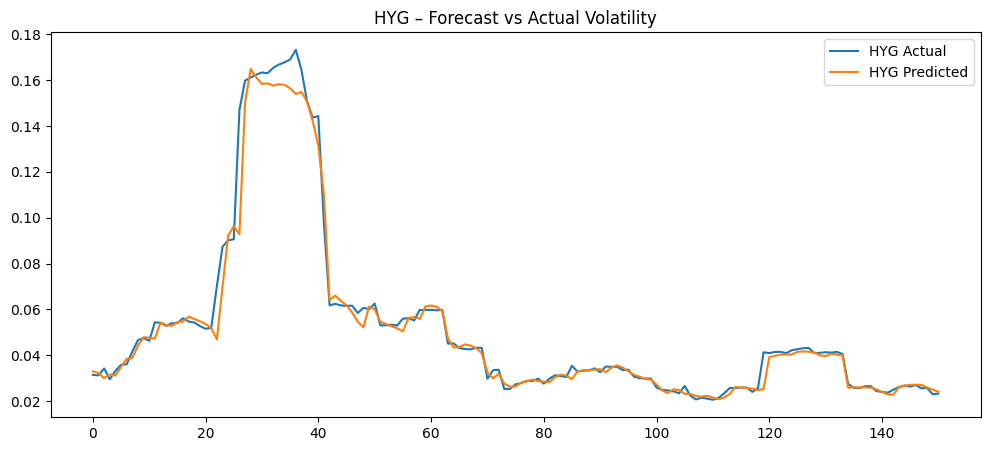

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Run inference ---
all_preds, all_trues, all_tids = [], [], []

with torch.no_grad():
    for tid, X, y in val_loader:
        tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)
        preds = MODEL(tid, X)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
        all_tids.append(tid.cpu().numpy())

preds_scaled = np.concatenate(all_preds)
trues_scaled = np.concatenate(all_trues)
tids = np.concatenate(all_tids)

# --- Invert scaling and exp back to vol ---
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
preds_vol, trues_vol = np.empty_like(preds_scaled), np.empty_like(trues_scaled)

for tid in np.unique(tids):
    mask = (tids == tid)
    tkr = id_to_ticker[int(tid)]
    sc_y = scalers[tkr]["y"]
    p_log = sc_y.inverse_transform(preds_scaled[mask].reshape(-1, 1)).ravel()
    y_log = sc_y.inverse_transform(trues_scaled[mask].reshape(-1, 1)).ravel()
    preds_vol[mask] = np.exp(p_log)
    trues_vol[mask] = np.exp(y_log)

# --- Compute aggregate metrics ---
rmse = np.sqrt(mean_squared_error(trues_vol, preds_vol))
mae = mean_absolute_error(trues_vol, preds_vol)
print(f"📊 Validation RMSE (vol): {rmse:.6f} | MAE: {mae:.6f}")

# --- Per-ticker metrics ---
rows = []
for tid in np.unique(tids):
    tkr = id_to_ticker[int(tid)]
    m = (tids == tid)
    rows.append({
        "ticker": tkr,
        "rmse": np.sqrt(mean_squared_error(trues_vol[m], preds_vol[m])),
        "mae": mean_absolute_error(trues_vol[m], preds_vol[m]),
        "n": int(m.sum())
    })
metrics_df = pd.DataFrame(rows).sort_values("rmse")
display(metrics_df.head(15))

# --- Plot a few representative tickers ---
plt.figure(figsize=(12,5))
top_ticker = metrics_df.iloc[0]["ticker"]
mask = (tids == list(id_to_ticker.keys())[list(id_to_ticker.values()).index(top_ticker)])
plt.plot(trues_vol[mask][:200], label=f"{top_ticker} Actual")
plt.plot(preds_vol[mask][:200], label=f"{top_ticker} Predicted")
plt.title(f"{top_ticker} – Forecast vs Actual Volatility")
plt.legend()
plt.show()


In [10]:
import os
import torch

# Save the entire model object (architecture + weights)
os.makedirs("checkpoints", exist_ok=True)
full_model_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}_full.pth"
torch.save(model, full_model_path)
print(f"💾 Saved full model object to: {full_model_path}")

💾 Saved full model object to: checkpoints/global_vol_forecaster_win40_h1_cpu_full.pth


In [13]:

import pickle
# Save as pickle files
os.makedirs("checkpoints", exist_ok=True)

# 1) Full model object (.pkl) — simple to load but depends on module path staying the same
full_pkl_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}_full.pkl"
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)
print(f"💾 Saved full model (pickle) to: {full_pkl_path}")

# 2) Portable bundle (.pkl) — recommended for robustness
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,  # for reference
    "state_dict": model.state_dict(),
    "cfg": cfg,
    "features": features,
    "ticker_to_id": ticker_to_id,
    "scalers": scalers,
}
bundle_pkl_path = f"checkpoints/global_vol_forecaster_strong_baseline_bundle.pkl"
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)
print(f"💾 Saved portable bundle (pickle) to: {bundle_pkl_path}")

💾 Saved full model (pickle) to: checkpoints/global_vol_forecaster_win40_h1_cpu_full.pkl
💾 Saved portable bundle (pickle) to: checkpoints/global_vol_forecaster_strong_baseline_bundle.pkl


In [9]:
out_path = "../data/metrics/global_lstm_metrics.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
metrics_df.to_csv(out_path, index=False)
print(f"Saved metrics to: {out_path}")

Saved metrics to: ../data/metrics/global_lstm_metrics.csv


In [ ]:

DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Prepare inverse mapping ---
id_to_ticker = {v: k for k, v in ticker_to_id.items()}

# --- Collect forecasts ---
forecast_rows = []
window = cfg.window
feats = ["return"] + (cfg.extra_features or [])

with torch.no_grad():
    for tkr, g in multi_df.groupby("ticker"):
        if len(g) < window:
            continue
        sc_x = scalers[tkr]["x"]
        sc_y = scalers[tkr]["y"]

        g_sorted = g.sort_values("date").copy()
        X_recent = g_sorted[feats].iloc[-window:].values
        X_scaled = sc_x.transform(X_recent)

        tid = torch.tensor([ticker_to_id[tkr]], dtype=torch.long, device=DEVICE)
        Xb = torch.tensor(X_scaled[None, :, :], dtype=torch.float32, device=DEVICE)

        pred_scaled = MODEL(tid, Xb).cpu().item()
        pred_log = sc_y.inverse_transform([[pred_scaled]])[0, 0]
        pred_vol = np.exp(pred_log)  # inverse log scaling

        last_date = g_sorted["date"].iloc[-1]
        forecast_rows.append({
            "ticker": tkr,
            "last_date": last_date,
            "forecast_date": last_date + timedelta(days=1),
            "forecast_vol": pred_vol
        })

# --- Build DataFrame ---
forecast_df = pd.DataFrame(forecast_rows)
forecast_df.sort_values("ticker", inplace=True)
forecast_df.reset_index(drop=True, inplace=True)

print(f"✅ Generated forecasts for {len(forecast_df)} tickers.")
display(forecast_df.head())

# --- Save to CSV ---
out_path = "../data/forecasts/global_vol_forecasts.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
forecast_df.to_csv(out_path, index=False)
print(f"📁 Saved next-day forecasts to: {out_path}")


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: U

✅ Generated forecasts for 104 tickers.


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\sklearn\utils\validation.py:2749: U

,ticker,last_date,forecast_date,forecast_vol
0,AAPL,2025-10-08,2025-10-09,0.238698
1,ABBV,2025-10-08,2025-10-09,0.340883
2,ABT,2025-10-08,2025-10-09,0.116691
3,ADI,2025-10-08,2025-10-09,0.241330
4,AEP,2025-10-08,2025-10-09,0.157992


📁 Saved next-day forecasts to: ../data/forecasts/global_vol_forecasts.csv


# Run 5: Add richer features to strong baseline

In [23]:
# ============================================================
# 🌍 Enhanced GlobalVolForecaster — Internal Market Stress Feature
# ============================================================
from volsense_pkg.models.global_vol_forecaster import (
    TrainConfig,
    train_global_model
)
# --- Parameters ------------------------------------------------
WINDOW      = 40
HORIZONS    = 1
STRIDE      = 1
VAL_START   = "2025-01-01"
DEVICE      = "cpu"
EPS         = 1e-6

# --- Copy & Ensure Correct Types -------------------------------
multi_df = pd.read_csv("../data/processed/global_volatility_dataset.csv")
multi_df = multi_df.copy()
multi_df["date"] = pd.to_datetime(multi_df["date"], errors="coerce")
multi_df.dropna(subset=["date"], inplace=True)
multi_df.sort_values(["ticker", "date"], inplace=True)
multi_df.reset_index(drop=True, inplace=True)

# --- Log-vol target --------------------------------------------
multi_df["realized_vol_log"] = np.log(multi_df["realized_vol"] + EPS)

# --- Rolling realized vols (3d and 10d) ------------------------
def roll_vol(s, w):
    return s.rolling(w, min_periods=1).std() * np.sqrt(252)

multi_df["vol_3d"]  = multi_df.groupby("ticker")["return"].transform(lambda s: roll_vol(s, 3)).groupby(multi_df["ticker"]).shift(1)
multi_df["vol_10d"] = multi_df.groupby("ticker")["return"].transform(lambda s: roll_vol(s, 10)).groupby(multi_df["ticker"]).shift(1)

# --- Market stress proxy (no external data) --------------------
# Cross-sectional median absolute return per day (shifted 1 day)
daily_stress = (
    multi_df.groupby("date")["return"].apply(lambda x: np.median(np.abs(x)))
    .shift(1)
    .rename("market_stress")
    .reset_index()
)
multi_df = multi_df.merge(daily_stress, on="date", how="left")

# --- Time-based cyclical features ------------------------------
multi_df["day_of_week"] = multi_df["date"].dt.dayofweek / 6.0
multi_df["month_sin"]   = np.sin(2 * np.pi * multi_df["date"].dt.month / 12)
multi_df["month_cos"]   = np.cos(2 * np.pi * multi_df["date"].dt.month / 12)

# --- Fill any residual NaNs per ticker --------------------------
for col in ["vol_3d", "vol_10d"]:
    multi_df[col] = multi_df.groupby("ticker")[col].transform(lambda s: s.ffill().bfill())
multi_df["market_stress"] = multi_df["market_stress"].fillna(method="ffill").fillna(method="bfill")

# --- Config object holds all hyperparameters -----------------
cfg = TrainConfig(
    epochs=25,
    lr=3e-4,
    batch_size=256,
    device="cpu",
    val_start="2025-01-01",
    window=40,
    horizons=1,
    stride=1,
    target_col="realized_vol_log",
    extra_features=["vol_3d", "vol_10d", "market_stress", "day_of_week", "month_sin", "month_cos"]
)

# --- Train the model (everything handled internally) ---------
model, history, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)

print("\n✅ Training complete with feature set:", features)


C:\Users\rahul\AppData\Local\Temp\ipykernel_13308\4240558218.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  multi_df["market_stress"] = multi_df["market_stress"].fillna(method="ffill").fillna(method="bfill")



🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/25 | Train Loss: 0.1018 | Val Loss: 0.0649
Epoch 1/25 | Train Loss: 0.1018 | Val Loss: 0.0649
Epoch 2/25 | Train Loss: 0.0499 | Val Loss: 0.0541
Epoch 2/25 | Train Loss: 0.0499 | Val Loss: 0.0541
Epoch 3/25 | Train Loss: 0.0429 | Val Loss: 0.0501
Epoch 3/25 | Train Loss: 0.0429 | Val Loss: 0.0501
Epoch 4/25 | Train Loss: 0.0405 | Val Loss: 0.0497
Epoch 4/25 | Train Loss: 0.0405 | Val Loss: 0.0497
Epoch 5/25 | Train Loss: 0.0390 | Val Loss: 0.0477
Epoch 5/25 | Train Loss: 0.0390 | Val Loss: 0.0477
Epoch 6/25 | Train Loss: 0.0378 | Val Loss: 0.0470
Epoch 6/25 | Train Loss: 0.0378 | Val Loss: 0.0470
Epoch 7/25 | Train Loss: 0.0368 | Val Loss: 0.0459
Epoch 7/25 | Train Loss: 0.0368 | Val Loss: 0.0459
Epoch 8/25 | Train Loss: 0.0362 | Val Loss: 0.0456
Epoch 8/25 | Train Loss: 0.0362 | Val Loss: 0.0456
Epoch 9/25 | Train Loss: 0.0355 | Val Loss: 0.0448
Epoch 9/25 | Train Loss: 0.0355 | Val Loss: 0.0448
Epoch 10/25 | Train Loss: 0.035

In [24]:

import pickle
# Save as pickle files
os.makedirs("checkpoints", exist_ok=True)

# 1) Full model object (.pkl) — simple to load but depends on module path staying the same
full_pkl_path = f"checkpoints/global_vol_forecaster_win{cfg.window}_h{cfg.horizons}_{cfg.device}_full.pkl"
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)
print(f"💾 Saved full model (pickle) to: {full_pkl_path}")

# 2) Portable bundle (.pkl) — recommended for robustness
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,  # for reference
    "state_dict": model.state_dict(),
    "cfg": cfg,
    "features": features,
    "ticker_to_id": ticker_to_id,
    "scalers": scalers,
}
bundle_pkl_path = f"checkpoints/global_vol_forecaster_w_rolling_vol_bundle.pkl"
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)
print(f"💾 Saved portable bundle (pickle) to: {bundle_pkl_path}")

💾 Saved full model (pickle) to: checkpoints/global_vol_forecaster_win40_h1_cpu_full.pkl
💾 Saved portable bundle (pickle) to: checkpoints/global_vol_forecaster_w_rolling_vol_bundle.pkl


📊 Validation RMSE (vol): 0.038167 | MAE: 0.016854


,ticker,rmse,mae,n
44,HYG,0.005863,0.002812,151
88,TLT,0.007349,0.004707,151
37,GLD,0.009504,0.007324,151
31,DUK,0.010319,0.006305,151
84,SO,0.010687,0.007280,151
50,KO,0.011038,0.006551,151
4,AEP,0.012025,0.008066,151
71,PG,0.012118,0.007861,151
19,CL,0.012408,0.008601,151
42,HD,0.013922,0.009795,151


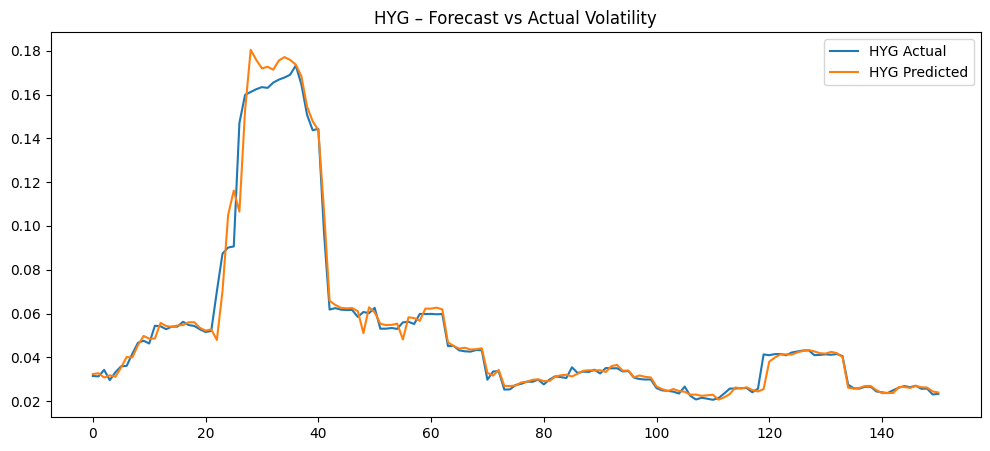

In [ ]:
# ============================================================
# 🌍 Evaluation — GlobalVolForecaster (Single Horizon)
# ============================================================

DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Run inference ---
all_preds, all_trues, all_tids = [], [], []

with torch.no_grad():
    for tid, X, y in val_loader:
        tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)
        preds = MODEL(tid, X)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
        all_tids.append(tid.cpu().numpy())

preds_scaled = np.concatenate(all_preds)
trues_scaled = np.concatenate(all_trues)
tids = np.concatenate(all_tids)

# --- Invert scaling and transform back to volatility ---
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
preds_vol, trues_vol = np.empty_like(preds_scaled), np.empty_like(trues_scaled)

for tid in np.unique(tids):
    mask = (tids == tid)
    tkr = id_to_ticker[int(tid)]
    sc_y = scalers[tkr]
    # Use only the y-scaler for target_col (the full feature scaler works fine)
    p_log = sc_y.inverse_transform(
        np.hstack([np.zeros((mask.sum(), len(features)-1)), preds_scaled[mask].reshape(-1, 1)])
    )[:, -1]
    y_log = sc_y.inverse_transform(
        np.hstack([np.zeros((mask.sum(), len(features)-1)), trues_scaled[mask].reshape(-1, 1)])
    )[:, -1]
    preds_vol[mask] = np.exp(p_log)
    trues_vol[mask] = np.exp(y_log)

# --- Compute aggregate metrics ---
rmse = np.sqrt(mean_squared_error(trues_vol, preds_vol))
mae = mean_absolute_error(trues_vol, preds_vol)
print(f"📊 Validation RMSE (vol): {rmse:.6f} | MAE: {mae:.6f}")

# --- Per-ticker metrics ---
rows = []
for tid in np.unique(tids):
    tkr = id_to_ticker[int(tid)]
    m = (tids == tid)
    rows.append({
        "ticker": tkr,
        "rmse": np.sqrt(mean_squared_error(trues_vol[m], preds_vol[m])),
        "mae": mean_absolute_error(trues_vol[m], preds_vol[m]),
        "n": int(m.sum())
    })
metrics_df = pd.DataFrame(rows).sort_values("rmse").reset_index(drop=True)
metrics_path = "..data/metrics/global_lstm_metrics_v2.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics saved to: {metrics_path}")

# --- Representative ticker plot ---
plt.figure(figsize=(12,5))
top_ticker = metrics_df.iloc[0]["ticker"]
mask = (tids == list(id_to_ticker.keys())[list(id_to_ticker.values()).index(top_ticker)])
plt.plot(trues_vol[mask][:200], label=f"{top_ticker} Actual", linewidth=1.2)
plt.plot(preds_vol[mask][:200], label=f"{top_ticker} Predicted", linewidth=1.2)
plt.title(f"{top_ticker} – Forecast vs Actual Volatility")
plt.legend()
plt.show()

display(metrics_df.head(15))


In [26]:
metrics_df.to_csv("../data/processed/global_lstm_metrics_rolling_vol_feats.csv", index=False)

✅ Baseline Validation RMSE: 0.210552


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


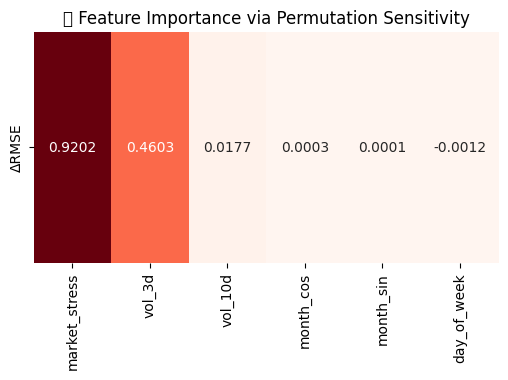


🏆 Top 10 Best Predicted Tickers


,ticker,rmse
44,HYG,0.134595
31,DUK,0.144444
66,NVDA,0.146142
50,KO,0.147062
25,CRM,0.147287
35,GE,0.148834
7,AMT,0.150924
29,DIA,0.151108
42,HD,0.151507
38,GME,0.151524



⚠️ 10 Hardest-to-Predict Tickers


,ticker,rmse
47,JNJ,0.278665
45,INTC,0.278950
101,XEL,0.281264
80,SCHW,0.282767
53,LMT,0.289992
91,TXN,0.295841
67,ORCL,0.308664
22,COIN,0.325749
6,AMD,0.332527
92,UNH,0.361130


C:\Users\rahul\AppData\Local\Temp\ipykernel_13308\1880947908.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_by_ticker.head(10), x="ticker", y="rmse", palette="Greens_r")


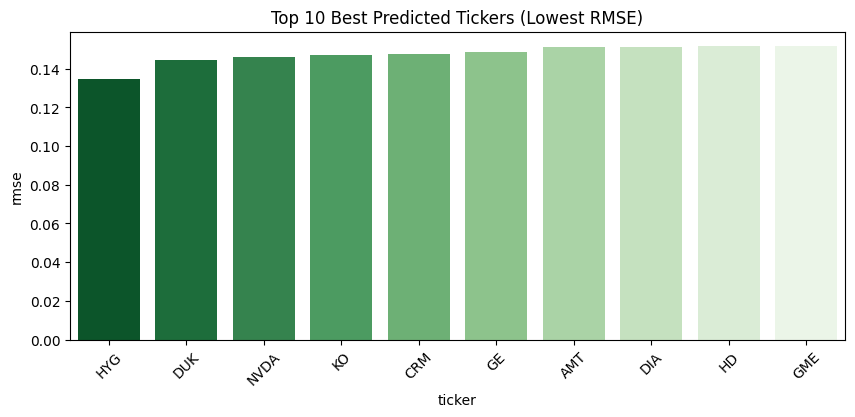

C:\Users\rahul\AppData\Local\Temp\ipykernel_13308\1880947908.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_by_ticker.tail(10), x="ticker", y="rmse", palette="Reds_r")


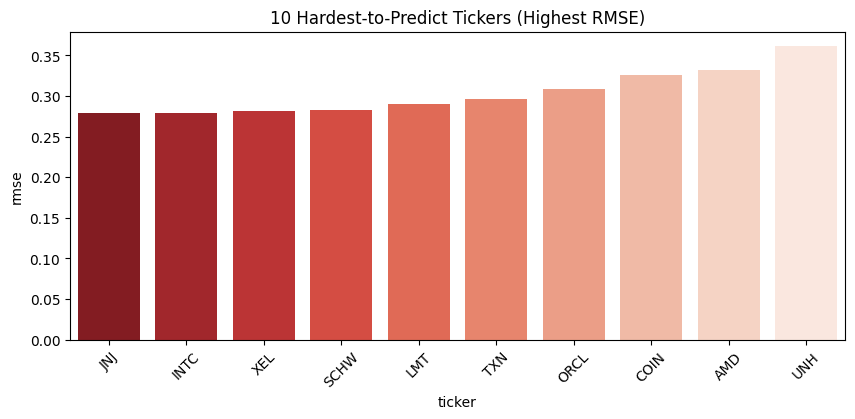

In [28]:
# ============================================================
# 🔍 Feature Importance + RMSE Ranking (fixed for 3D input)
# ============================================================

import seaborn as sns

DEVICE = "cpu"
model.eval()

# --- Step 1: Get baseline predictions ------------------------
true_vals, preds_vals, ticker_ids = [], [], []

for batch in val_loader:
    # handle both (tid, X, y) and (X, y, tid)
    if isinstance(batch, (list, tuple)) and len(batch) == 3:
        if batch[0].ndim == 1 and batch[1].ndim >= 2:
            tid, X, y = batch
        else:
            X, y, tid = batch
    else:
        raise ValueError("Unexpected batch format from val_loader")

    tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)

    # ensure correct shape [B, W, F]
    if X.ndim == 2:
        X = X.unsqueeze(1)
    elif X.ndim == 1:
        X = X.unsqueeze(0).unsqueeze(-1)

    B, W, F = X.shape
    assert F + 12 == model.lstm.input_size, f"Input feature count mismatch: got {F}, expected {model.lstm.input_size-12}"

    with torch.no_grad():
        pred = model(tid, X).squeeze().cpu().numpy()

    preds_vals.append(pred)
    true_vals.append(y.cpu().numpy())
    ticker_ids.append(tid.cpu().numpy())

true_vals = np.concatenate(true_vals)
preds_vals = np.concatenate(preds_vals)
ticker_ids = np.concatenate(ticker_ids)
base_rmse = np.sqrt(mean_squared_error(true_vals, preds_vals))
print(f"✅ Baseline Validation RMSE: {base_rmse:.6f}")

# --- Step 2: Permutation-based feature importance ------------
feature_importance = {}

# pick one batch for sensitivity analysis
tidb, Xb, yb = next(iter(val_loader))
tidb, Xb, yb = tidb.to(DEVICE), Xb.to(DEVICE), yb.to(DEVICE)
if Xb.ndim == 2:
    Xb = Xb.unsqueeze(1)

with torch.no_grad():
    base_pred = model(tidb, Xb).cpu().numpy()
base_rmse_sample = np.sqrt(mean_squared_error(yb.cpu().numpy(), base_pred))

for i, feat in enumerate(EXTRA_FEATURES):
    X_shuff = Xb.clone()
    perm = torch.randperm(X_shuff.shape[0])
    X_shuff[:, :, i] = X_shuff[perm, :, i]  # shuffle feature i
    with torch.no_grad():
        pred_perm = model(tidb, X_shuff).cpu().numpy()
    rmse_perm = np.sqrt(mean_squared_error(yb.cpu().numpy(), pred_perm))
    feature_importance[feat] = rmse_perm - base_rmse_sample

# --- Step 3: Plot feature importance heatmap -----------------
imp_df = pd.DataFrame.from_dict(feature_importance, orient="index", columns=["ΔRMSE"])
imp_df.sort_values("ΔRMSE", ascending=False, inplace=True)

plt.figure(figsize=(6, 3))
sns.heatmap(imp_df.T, annot=True, fmt=".4f", cmap="Reds", cbar=False)
plt.title("🔍 Feature Importance via Permutation Sensitivity")
plt.show()

# --- Step 4: Ticker-wise RMSE ranking -------------------------
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
df_rmse = pd.DataFrame({
    "ticker": [id_to_ticker[i] for i in ticker_ids],
    "true": true_vals,
    "pred": preds_vals
})
df_rmse["error_sq"] = (df_rmse["true"] - df_rmse["pred"]) ** 2

rmse_by_ticker = (
    df_rmse.groupby("ticker")["error_sq"]
    .mean()
    .apply(np.sqrt)
    .reset_index(name="rmse")
    .sort_values("rmse")
)

print("\n🏆 Top 10 Best Predicted Tickers")
display(rmse_by_ticker.head(10))

print("\n⚠️ 10 Hardest-to-Predict Tickers")
display(rmse_by_ticker.tail(10))

plt.figure(figsize=(10, 4))
sns.barplot(data=rmse_by_ticker.head(10), x="ticker", y="rmse", palette="Greens_r")
plt.title("Top 10 Best Predicted Tickers (Lowest RMSE)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=rmse_by_ticker.tail(10), x="ticker", y="rmse", palette="Reds_r")
plt.title("10 Hardest-to-Predict Tickers (Highest RMSE)")
plt.xticks(rotation=45)
plt.show()


# Run 6: Add attention layer and residual head, remove temporal features

In [3]:
# ============================================================
# 🌍 Phase 3 — Enhanced GlobalVolForecaster Training (v2)
# Compatible with build_global_splits(df, cfg)
# ============================================================

# --- 1. Feature Engineering ---------------------------------
multi_df = pd.read_csv("../data/processed/global_volatility_dataset.csv")
multi_df = multi_df.copy()
EPS = 1e-6

multi_df["realized_vol_log"] = np.log(multi_df["realized_vol"] + EPS)
multi_df["vol_3d"]  = multi_df.groupby("ticker")["realized_vol"].transform(lambda x: x.rolling(3).mean())
multi_df["vol_10d"] = multi_df.groupby("ticker")["realized_vol"].transform(lambda x: x.rolling(10).mean())
multi_df["market_stress"] = multi_df.groupby("date")["return"].transform(lambda x: x.std())
multi_df["market_stress_1d_lag"] = multi_df.groupby("ticker")["market_stress"].shift(1)
multi_df["vol_ratio"] = multi_df["vol_3d"] / (multi_df["vol_10d"] + EPS)
multi_df["vol_chg"] = multi_df["vol_3d"] - multi_df["vol_10d"]
multi_df["vol_vol"] = multi_df.groupby("ticker")["realized_vol"].transform(lambda x: x.rolling(10).std())

def rolling_skew(x):
    if len(x) < 3:
        return np.nan
    mean, std = np.mean(x), np.std(x)
    return np.mean(((x - mean) / (std + EPS)) ** 3)

multi_df["skew_5d"] = multi_df.groupby("ticker")["return"].transform(lambda x: x.rolling(5).apply(rolling_skew))


multi_df = multi_df.groupby("ticker").apply(lambda g: g.ffill().bfill()).reset_index(drop=True)

# --- 2. Feature list ----------------------------------------
EXTRA_FEATURES = [
    "vol_3d", "vol_10d", "vol_ratio", "vol_chg",
    "vol_vol", "market_stress", "market_stress_1d_lag",
    "skew_5d"
]

# --- 3. Config -----------------------------------------------
cfg = TrainConfig(
    window=40,
    horizons=1,
    stride=1,
    val_start="2025-01-01",
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    epochs=25,
    lr=3e-4,
    batch_size=256,
    oversample_high_vol=True,
    cosine_schedule=True,
    device="cpu"
)

# --- 4. Train the model --------------------------------------
model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(
    multi_df, cfg
)

print(f"\n✅ Training complete for {len(ticker_to_id)} tickers.")
print(f"📊 Features used: {features}")


C:\Users\rahul\AppData\Local\Temp\ipykernel_35580\2939161782.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multi_df = multi_df.groupby("ticker").apply(lambda g: g.ffill().bfill()).reset_index(drop=True)



🚀 Training GlobalVolForecaster on 104 tickers...

Epoch 1/25 | Train Loss: 0.0815 | Val Loss: 0.0231
Epoch 1/25 | Train Loss: 0.0815 | Val Loss: 0.0231
Epoch 2/25 | Train Loss: 0.0208 | Val Loss: 0.0165
Epoch 2/25 | Train Loss: 0.0208 | Val Loss: 0.0165
Epoch 3/25 | Train Loss: 0.0156 | Val Loss: 0.0139
Epoch 3/25 | Train Loss: 0.0156 | Val Loss: 0.0139
Epoch 4/25 | Train Loss: 0.0127 | Val Loss: 0.0131
Epoch 4/25 | Train Loss: 0.0127 | Val Loss: 0.0131
Epoch 5/25 | Train Loss: 0.0114 | Val Loss: 0.0130
Epoch 5/25 | Train Loss: 0.0114 | Val Loss: 0.0130
Epoch 6/25 | Train Loss: 0.0105 | Val Loss: 0.0112
Epoch 6/25 | Train Loss: 0.0105 | Val Loss: 0.0112
Epoch 7/25 | Train Loss: 0.0097 | Val Loss: 0.0106
Epoch 7/25 | Train Loss: 0.0097 | Val Loss: 0.0106
Epoch 8/25 | Train Loss: 0.0091 | Val Loss: 0.0101
Epoch 8/25 | Train Loss: 0.0091 | Val Loss: 0.0101
Epoch 9/25 | Train Loss: 0.0087 | Val Loss: 0.0098
Epoch 9/25 | Train Loss: 0.0087 | Val Loss: 0.0098
Epoch 10/25 | Train Loss: 0.008

In [6]:
# Ensure checkpoints directory exists
os.makedirs("checkpoints", exist_ok=True)

# 1) Save the full model object (pickle)
# Note: Loading later requires the same module path for the model class.
full_pkl_path = f"checkpoints/global_vol_forecaster_optimized_feats_attn_layer_full.pkl"
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)
print(f"💾 Saved full model (pickle) to: {full_pkl_path}")

# 2) Save a portable bundle: state_dict + config + scalers + mappings
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,
    "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
    "cfg": cfg,
    "features": features,
    "ticker_to_id": ticker_to_id,
    "scalers": scalers,
}
bundle_pkl_path = f"checkpoints/global_vol_forecaster_optimized_feats_attn_layer_bundle.pkl"
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)
print(f"💾 Saved portable bundle (pickle) to: {bundle_pkl_path}")

💾 Saved full model (pickle) to: checkpoints/global_vol_forecaster_optimized_feats_attn_layer_full.pkl
💾 Saved portable bundle (pickle) to: checkpoints/global_vol_forecaster_optimized_feats_attn_layer_bundle.pkl


📊 Validation RMSE (vol): 0.031419 | MAE: 0.014566
✅ Metrics saved to: ../data/metrics/global_lstm_attn_layer_metrics_v2.csv


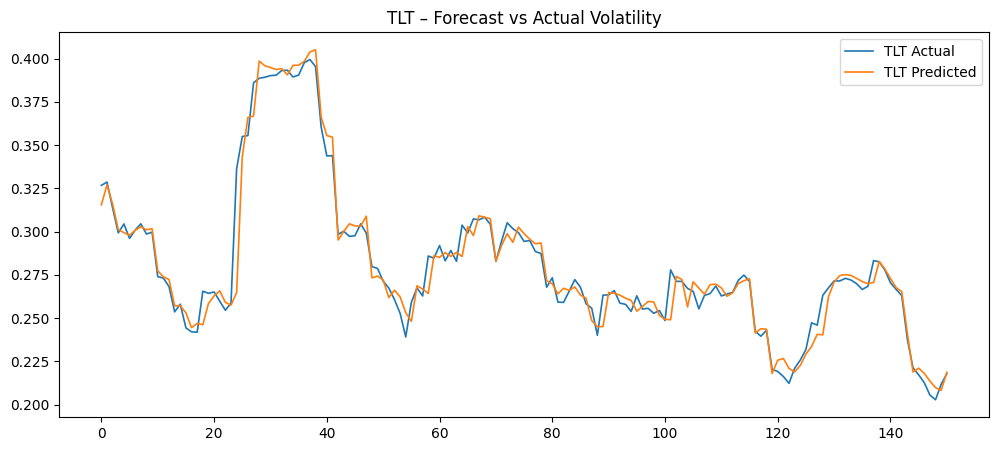

,ticker,rmse,mae,n
0,TLT,0.009141,0.005608,151
1,HYG,0.009273,0.004608,151
2,GLD,0.010637,0.007316,151
3,DUK,0.011634,0.007145,151
4,SO,0.012119,0.007502,151
5,KO,0.012944,0.007767,151
6,AEP,0.013105,0.008410,151
7,PG,0.013868,0.008968,151
8,CL,0.014265,0.009218,151
9,AMT,0.014879,0.010138,151


In [10]:
# ============================================================
# 🌍 Evaluation — GlobalVolForecaster (Single Horizon)
# ============================================================

DEVICE = cfg.device
MODEL = model.to(DEVICE)
MODEL.eval()

# --- Run inference ---
all_preds, all_trues, all_tids = [], [], []

with torch.no_grad():
    for tid, X, y in val_loader:
        tid, X, y = tid.to(DEVICE), X.to(DEVICE), y.to(DEVICE)
        preds = MODEL(tid, X)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
        all_tids.append(tid.cpu().numpy())

preds_scaled = np.concatenate(all_preds)
trues_scaled = np.concatenate(all_trues)
tids = np.concatenate(all_tids)

# --- Invert scaling and transform back to volatility ---
id_to_ticker = {v: k for k, v in ticker_to_id.items()}
preds_vol, trues_vol = np.empty_like(preds_scaled), np.empty_like(trues_scaled)

for tid in np.unique(tids):
    mask = (tids == tid)
    tkr = id_to_ticker[int(tid)]
    sc_y = scalers[tkr]
    # Use only the y-scaler for target_col (the full feature scaler works fine)
    p_log = sc_y.inverse_transform(
        np.hstack([np.zeros((mask.sum(), len(features)-1)), preds_scaled[mask].reshape(-1, 1)])
    )[:, -1]
    y_log = sc_y.inverse_transform(
        np.hstack([np.zeros((mask.sum(), len(features)-1)), trues_scaled[mask].reshape(-1, 1)])
    )[:, -1]
    preds_vol[mask] = np.exp(p_log)
    trues_vol[mask] = np.exp(y_log)

# --- Compute aggregate metrics ---
rmse = np.sqrt(mean_squared_error(trues_vol, preds_vol))
mae = mean_absolute_error(trues_vol, preds_vol)
print(f"📊 Validation RMSE (vol): {rmse:.6f} | MAE: {mae:.6f}")

# --- Per-ticker metrics ---
rows = []
for tid in np.unique(tids):
    tkr = id_to_ticker[int(tid)]
    m = (tids == tid)
    rows.append({
        "ticker": tkr,
        "rmse": np.sqrt(mean_squared_error(trues_vol[m], preds_vol[m])),
        "mae": mean_absolute_error(trues_vol[m], preds_vol[m]),
        "n": int(m.sum())
    })
metrics_df = pd.DataFrame(rows).sort_values("rmse").reset_index(drop=True)
metrics_path = "../data/metrics/global_lstm_attn_layer_metrics_v2.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics saved to: {metrics_path}")

# --- Representative ticker plot ---
plt.figure(figsize=(12,5))
top_ticker = metrics_df.iloc[0]["ticker"]
mask = (tids == list(id_to_ticker.keys())[list(id_to_ticker.values()).index(top_ticker)])
plt.plot(trues_vol[mask][:200], label=f"{top_ticker} Actual", linewidth=1.2)
plt.plot(preds_vol[mask][:200], label=f"{top_ticker} Predicted", linewidth=1.2)
plt.title(f"{top_ticker} – Forecast vs Actual Volatility")
plt.legend()
plt.show()

display(metrics_df.head(15))

C:\Users\rahul\AppData\Local\Temp\ipykernel_35580\527484460.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=importances, palette="coolwarm")


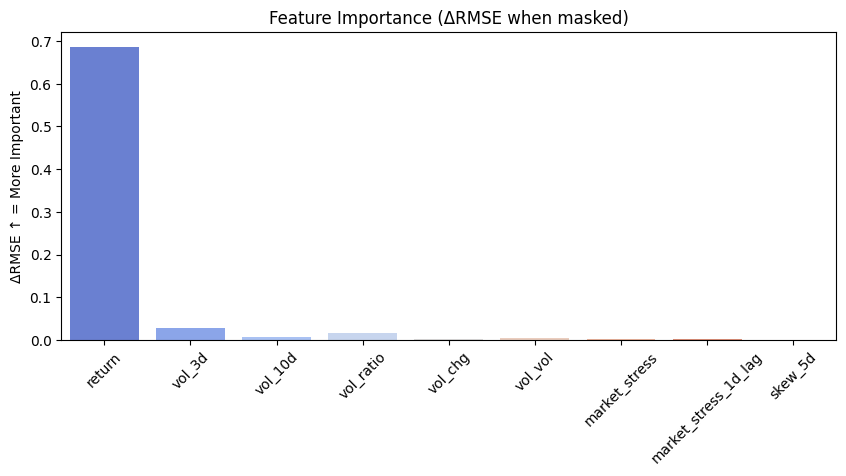

✅ Easiest (Best-Fit) Tickers:


,ticker,rmse,mae
0,TLT,0.009141,0.005608
1,HYG,0.009273,0.004608
2,GLD,0.010637,0.007316
3,DUK,0.011634,0.007145
4,SO,0.012119,0.007502


⚠️ Hardest (High-Volatility / Poor-Fit) Tickers:


,ticker,rmse,mae
102,ORCL,0.083439,0.031813
101,PARA,0.067320,0.030186
100,WBD,0.064523,0.026977
99,AMD,0.064459,0.024068
98,COIN,0.063457,0.032978


In [12]:
# ============================================================
# 🔍 Feature Importance via Leave-One-Out RMSE (Proxy)
# ============================================================

MODEL.eval()
DEVICE = cfg.device

# Sample subset for speed
sample_idx = random.sample(range(len(val_loader.dataset)), k=min(1000, len(val_loader.dataset)))
X_batch, y_batch, tkr_batch = [], [], []

for i in sample_idx:
    tid, X, y = val_loader.dataset[i]
    X_batch.append(X)
    y_batch.append(y)
    tkr_batch.append(tid)

X_batch = torch.stack(X_batch).to(DEVICE)
y_batch = torch.stack(y_batch).to(DEVICE)
tkr_batch = torch.tensor(tkr_batch).to(DEVICE)

# --- Baseline RMSE ---
with torch.no_grad():
    base_pred = MODEL(tkr_batch, X_batch).cpu().numpy()
base_rmse = np.sqrt(mean_squared_error(y_batch.cpu().numpy(), base_pred))

# --- Compute feature importance by masking ---
feature_names = ["return"] + (cfg.extra_features or [])
importances = []

for i, feat in enumerate(feature_names):
    X_masked = X_batch.clone()
    X_masked[:, :, i] = 0.0
    with torch.no_grad():
        masked_pred = MODEL(tkr_batch, X_masked).cpu().numpy()
    masked_rmse = np.sqrt(mean_squared_error(y_batch.cpu().numpy(), masked_pred))
    delta = masked_rmse - base_rmse
    importances.append(delta)

# --- Plot heatmap ---
plt.figure(figsize=(10, 4))
sns.barplot(x=feature_names, y=importances, palette="coolwarm")
plt.title("Feature Importance (ΔRMSE when masked)")
plt.xticks(rotation=45)
plt.ylabel("ΔRMSE ↑ = More Important")
plt.show()

# --- Best / Hardest tickers ---
best = metrics_df.nsmallest(5, "rmse")[["ticker", "rmse", "mae"]]
worst = metrics_df.nlargest(5, "rmse")[["ticker", "rmse", "mae"]]
print("✅ Easiest (Best-Fit) Tickers:")
display(best)
print("⚠️ Hardest (High-Volatility / Poor-Fit) Tickers:")
display(worst)
